In [2]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import pyDOE
from multiprocessing import Process
from scipy.stats import norm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params, update_sev_prevalence
from analysis_helpers import poisson_waiting_function

from multi_group_simulation import MultiGroupSimulation

In [3]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [4]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    inf_list = list()
    hosp_list = list()
    for group in sim.sims:
        df = group.sim_df
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [5]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

In [6]:
param_uncertainty = {
    'asymp_prob_mult': (24/47, 70/47), # Our nominal estimate for US population: 47%
    'inital_prev_mult': (0.5, 1.5),
    'R0': (1,4),
    'outside_inf_mult': (0.5, 1.5),
    'daily_self_report_prob': (0.22, 0.5),
    'ct_mult': (1,2),
    'ct_testing_ratio': (0.5, 1.5),
    'test_sensitivity': (0.4, 0.8),
    'test_noncompliance': (0.05, 0.15),
    'E_time': (1,3),
    'ID_time': (2,4),
    'Sy_time': (11,13),
    'virtual_noncompliance': (0.25, 0.75),
    'intermittent_non-compliance': (0.25,0.75),
    'virtual_r0_mult': (0.97, 1.5),
    'virtual_pop_size': (0,1), # Slider from min to max
}

uncertainty_params_list = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time', 'virtual_noncompliance', 'intermittent_non-compliance', 'virtual_r0_mult',
                           'virtual_pop_size']

nominal_param_dict = {
    'asymp_prob_mult': 1, # Our nominal estimate for US population: 47%
    'inital_prev_mult': 1,
    'R0': 2.5,
    'outside_inf_mult': 1,
    'daily_self_report_prob': 0.22,
    'ct_mult': 1,
    'ct_testing_ratio': 0.5,
    'test_sensitivity': 0.6,
    'test_noncompliance': 0.1,
    'E_time': 2,
    'ID_time': 3,
    'Sy_time': 12,
    'virtual_noncompliance': 0.5,
    'intermittent_non-compliance': 0.5,
    'virtual_r0_mult': 0.97,
    'virtual_pop_size': 0.71, # Slider from min to max
}

lb = list()
ub = list()

for param in uncertainty_params_list:
    lb.append(param_uncertainty[param][0])
    ub.append(param_uncertainty[param][1])

In [7]:
def get_nominal_params():
#     base_directory = '../src/simulations_v2/params/baseline_testing/steady_state/nominal/'
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/nominal/'
    
    ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
    ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
    gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
    gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

    interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                                   [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                                   [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                                   [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                                   [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                                   [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                                   [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                                   [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

    group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']
    
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    return params_list, interaction_matrix, group_names

In [8]:
def rescale_virtual_interaction_matrix(perc_compliant, group_sizes):
    interaction_matrix = np.array([[8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [8.8651, 2.2163, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 1],
                                    [0.17, 0.0435, 4, 0.1, 0.1, 1.2, 0.05, 0.2, 1.8],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.19, 0.05, 0.11, 6.9926, 1.7482, 0.05, 0.05, 0.05, 1],
                                    [0.04, 0.01, 0.53, 0.02, 0.00, 1, 0.15, 0.3, 1.56],
                                    [0.07, 0.02, 0.04, 0.03, 0.01, 0.28, 1.8, 0.2, 1.56],
                                    [0.03, 0.01, 0.07, 0.01, 0.00, 0.23, 0.08, 1.8, 1.56],
                                    [0.045, 0.011, 0.046, 0.034, 0.008, 0.091, 0.048, 0.12, 3.5]
                                   ])
    interaction_matrix[0,0] = (8.8651 + 2.2163) * (1 - perc_compliant)
    interaction_matrix[0,1] = (8.8651 + 2.2163) * (perc_compliant)
    interaction_matrix[1,1] = (8.8651 + 2.2163) * (perc_compliant)
    
    interaction_matrix[3,3] = (6.9926 + 1.7482) * (1 - perc_compliant)
    interaction_matrix[3,4] = (6.9926 + 1.7482) * perc_compliant
    interaction_matrix[4,4] = (6.9926 + 1.7482) * perc_compliant
    
    for i in range(interaction_matrix.shape[0]):
        for j in range(i):
            if ((i,j) == (0,0)) or ((i,j)==(0,1)) or ((i,j)==(1,1)):
                continue
            interaction_matrix[i,j] = interaction_matrix[j,i] * group_sizes[j] / group_sizes[i]
    return interaction_matrix


def get_virtual_params(perc_unmonitored, ug_pop, gs_other_pop):
    base_directory = '../src/simulations_v2/params/baseline_testing/res_instr_paper_mar_18/virtual_instruction/'

    gs_research_params = load_params(base_directory + 'grad_research_virtual.yaml')[1]
    faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age_virtual.yaml')[1]
    faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age_virtual.yaml')[1]
    faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age_virtual.yaml')[1]
    ithaca_community_params = load_params(base_directory + 'ithaca_community_virtual.yaml')[1]

    ug_off_campus_unmonitored_params = load_params(base_directory + 'ug_off_campus_unmonitored_virtual.yaml')[1]
    ug_off_campus_compliant_params = load_params(base_directory + 'ug_off_campus_compliant_virtual.yaml')[1]
    gs_other_unmonitored_params = load_params(base_directory + 'grad_other_unmonitored_virtual.yaml')[1]
    gs_other_compliant_params = load_params(base_directory + 'grad_other_compliant_virtual.yaml')[1]
    
#     total_ug_pop = ug_off_campus_unmonitored_params['population_size'] + ug_off_campus_compliant_params['population_size']
    ug_off_campus_unmonitored_params['population_size'] = np.ceil(perc_unmonitored * ug_pop)
    ug_off_campus_compliant_params['population_size'] = np.floor((1-perc_unmonitored) * ug_pop)
    
#     total_gs_other_pop = gs_other_unmonitored_params['population_size'] + gs_other_compliant_params['population_size']
    gs_other_unmonitored_params['population_size'] = np.ceil(perc_unmonitored * gs_other_pop)
    gs_other_compliant_params['population_size'] = np.floor((1-perc_unmonitored) * gs_other_pop)
    
    params_list = [ug_off_campus_unmonitored_params.copy(), ug_off_campus_compliant_params.copy(), gs_research_params.copy(), gs_other_unmonitored_params.copy(), gs_other_compliant_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    group_names = ['UG unmonitored', 'UG compliant', 'GS research', 'GS unmonitored', 'GS compliant', 'F/S student', 'F/S non-student', 'F/S off', 'Ithaca']
    virtual_group_sizes = list()
    for params in params_list:
        virtual_group_sizes.append(params['population_size'])
    interaction_matrix = rescale_virtual_interaction_matrix(1 - perc_unmonitored, virtual_group_sizes)
    
    return params_list, interaction_matrix, group_names

In [9]:
def get_test_FNR(sensitivity, compliance):
    if 1 - (sensitivity * compliance) > 1:
        print(sensitivity, compliance)
    return 1 - (sensitivity * compliance)

def adjust_params(uncertainty_point):
    res_params_list, res_interaction_matrix, res_group_names = get_nominal_params()
    virtual_persistent_noncompliance = uncertainty_point[12]
    virtual_ug_pop = 4500 * (1 - uncertainty_point[15]) + 7950 * uncertainty_point[15]
    virtual_gs_other_pop = 4770 * (1 - uncertainty_point[15]) + 5850 * uncertainty_point[15]
    virtual_params_list, virtual_interaction_matrix, virtual_group_names = get_virtual_params(virtual_persistent_noncompliance, virtual_ug_pop, virtual_gs_other_pop)

    # Asmptomatic Prob Mult
    for params in res_params_list:
        params['severity_prevalence'] = update_sev_prevalence(params['severity_prevalence'], uncertainty_point[0] * params['severity_prevalence'][0])
        if params['severity_prevalence'][0] > 1:
            params['severity_prevalence'] = [1,0,0,0]
    for params in virtual_params_list:
        params['severity_prevalence'] = update_sev_prevalence(params['severity_prevalence'], uncertainty_point[0] * params['severity_prevalence'][0])
        if params['severity_prevalence'][0] > 1:
            params['severity_prevalence'] = [1,0,0,0]
    
    # Initial Prevalence Mult
    for params in res_params_list:
        params['initial_ID_prevalence'] *= uncertainty_point[1]
    for params in virtual_params_list:
        params['initial_ID_prevalence'] *= uncertainty_point[1]
    
    # R0 adjustment
    res_interaction_matrix *= uncertainty_point[2]/2.5
    virtual_interaction_matrix *= uncertainty_point[2] * uncertainty_point[14]/2.5
    
    # Outside inf mult
    for params in res_params_list:
        params['daily_outside_infection_p'] *= uncertainty_point[3]
    for params in virtual_params_list:
        params['daily_outside_infection_p'] *= uncertainty_point[3]
    
    # Daily self-report prob
    for params in res_params_list:
        params['severe_symptoms_daily_self_report_p'] = uncertainty_point[4]
    for params in virtual_params_list:
        params['severe_symptoms_daily_self_report_p'] = uncertainty_point[4]
        
    # CT mult
    for params in res_params_list:
        params['cases_isolated_per_contact'] *= uncertainty_point[5]
    for params in virtual_params_list:
        params['cases_isolated_per_contact'] *= uncertainty_point[5]
    
    # CT testing ratio
    for params in res_params_list:
        params['contact_trace_testing_frac'] = uncertainty_point[6]
    for params in virtual_params_list:
        params['contact_trace_testing_frac'] = uncertainty_point[6]
    
    # Test sensitivity and Test compliance (note: non-compliance is provided in uncertainty point)
    for params in res_params_list:
        params['test_protocol_QFNR'] = get_test_FNR(uncertainty_point[7], 1-uncertainty_point[8])
    for params in virtual_params_list:
        params['test_protocol_QFNR'] = get_test_FNR(uncertainty_point[7], 1-(uncertainty_point[13]))

    # E_time, ID_time, Sy_time
    for params in res_params_list:
        params['exposed_time_function'] = poisson_waiting_function(7, uncertainty_point[9])
        params['ID_time_function'] = poisson_waiting_function(8, uncertainty_point[10])
        params['SyID_mild_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        params['SyID_severe_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
    
    for params in virtual_params_list:
        params['exposed_time_function'] = poisson_waiting_function(7, uncertainty_point[9])
        params['ID_time_function'] = poisson_waiting_function(8, uncertainty_point[10])
        params['SyID_mild_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        params['SyID_severe_time_function'] = poisson_waiting_function(20, uncertainty_point[11])
        
    return (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names)

In [10]:
def get_stats(inf_matrix):
    cornell_inf = np.array(inf_matrix)[:,:-1].sum(axis=1)
    ithaca_inf = np.array(inf_matrix)[:,-1]
    return np.quantile(cornell_inf, [0.1,0.5,0.9]), np.quantile(ithaca_inf, [0.1,0.5,0.9])

# Plotting Pessimistic Scenario params

In [54]:
def get_stats(inf_matrix):
    cornell_inf = np.array(inf_matrix)[:,:-1].sum(axis=1)
    ithaca_inf = np.array(inf_matrix)[:,-1]
    return np.quantile(cornell_inf, [0.1,0.5,0.9]), np.quantile(ithaca_inf, [0.1,0.5,0.9])

In [55]:
scenario_data = pd.DataFrame(columns=uncertainty_params_list+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90']+
                            ['vir_cornell_inf_10','vir_cornell_inf_50','vir_cornell_inf_90','vir_ithaca_inf_10','vir_ithaca_inf_50','vir_ithaca_inf_90'])

for i in range(200):
    file = open('apr_21_scenarios/point_'+str(i)+'.dill', 'rb')
    [uncertainty_point, res_inf_matrix, res_hosp_matrix, virtual_inf_matrix, virtual_hosp_matrix] = dill.load(file)
    file.close()

    new_row = dict()
    for index, col_name in enumerate(uncertainty_params_list):
        new_row[col_name] = uncertainty_point[index]

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

    vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
    new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
    new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
    new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
    new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
    new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
    new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
#     print(new_row)

    scenario_data = scenario_data.append(new_row, ignore_index=True)

In [56]:
import statsmodels.api as sm
residential_columns = scenario_data.columns[0:12]
residential_target = 'res_cornell_inf_50'
X_res = scenario_data[residential_columns]
Y_res_outcomes = np.array(scenario_data[[residential_target]])

X = sm.add_constant(X_res)
model = sm.OLS(Y_res_outcomes,X)
results = model.fit()
results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     16.30
Date:                Tue, 27 Apr 2021   Prob (F-statistic):           2.21e-23
Time:                        10:21:07   Log-Likelihood:                -1631.0
No. Observations:                 200   AIC:                             3288.
Df Residuals:                     187   BIC:                             3331.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    995.8849   1513.837      0.658      0.511   -1990.509    3982.278
asymp_prob_mult          941.9148    229.475      4.105      0.000     489.222    1394.607
inital_prev_mult        -190.9972    229.833     -0.831      0.407    -644.397     262.402
R0                       666.9477     76.599      8.707      0.000     515.839     818.057
outside_inf_mult         174.1239    224.662      0.775      0.439    -269.074     617.322
daily_self_report_prob  -680.6892    771.987     -0.882      0.379   -2203.612     842.234
ct_mult                -1163.4178    235.061     -4.949      0.000   -1627.130    -699.705
ct_testing_ratio        -924.5224    223.899     -4.129      0.000   -1366.215    -482.830
test_sensitivity       -2727.6250    549.398     -4.965      0.000   -3811.439   -1643.811
test_noncompliance      2361.9812   2214.006      1.067      0.287   -2005.657    6729.619
E_time                    31.2164    110.004      0.284      0.777    -185.792     248.225
ID_time                 -161.4988    109.711     -1.472      0.143    -377.929      54.932
Sy_time                  152.5914    109.064      1.399      0.163     -62.563     367.746
==============================================================================
Omnibus:                      121.377   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.245
Skew:                           2.359   Prob(JB):                    8.11e-161
Kurtosis:                      11.137   Cond. No.                         471.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
results_summary = results.summary()
results_as_html = results_summary.tables[1].as_html()
lr_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

In [63]:
# lr_summary_df[['coef', 'std err', 't', 'P>|t|']]

coef_normalized = list()
for param, value in dict(lr_summary_df['coef']).items():
    if param == 'const':
        coef_normalized.append(value)
        continue
    param_range = param_uncertainty[param][1] - param_uncertainty[param][0]
    coef_normalized.append(value * param_range)

# lr_summary_df['coef/range']
# dict(lr_summary_df['coef']).items()

In [59]:
coef_normalized

[995.8849,
 921.8740595744681,
 -190.9972,
 2000.8431,
 174.1239,
 -190.59297600000002,
 -1163.4178,
 -924.5224,
 -1091.05,
 236.19812,
 62.4328,
 -322.9976,
 305.1828]

In [64]:
lr_summary_df['coef*range'] = coef_normalized

In [65]:
lr_summary_df.round(1)

,coef,std err,t,P>|t|,[0.025,0.975],coef*range
const,995.9,1513.8,0.7,0.5,-1990.5,3982.3,995.9
asymp_prob_mult,941.9,229.5,4.1,0.0,489.2,1394.6,921.9
inital_prev_mult,-191.0,229.8,-0.8,0.4,-644.4,262.4,-191.0
R0,666.9,76.6,8.7,0.0,515.8,818.1,2000.8
outside_inf_mult,174.1,224.7,0.8,0.4,-269.1,617.3,174.1
daily_self_report_prob,-680.7,772.0,-0.9,0.4,-2203.6,842.2,-190.6
ct_mult,-1163.4,235.1,-4.9,0.0,-1627.1,-699.7,-1163.4
ct_testing_ratio,-924.5,223.9,-4.1,0.0,-1366.2,-482.8,-924.5
test_sensitivity,-2727.6,549.4,-5.0,0.0,-3811.4,-1643.8,-1091.0
test_noncompliance,2362.0,2214.0,1.1,0.3,-2005.7,6729.6,236.2


In [6]:
lr_results = {'Intercept': 995.88,
'asymp_prob_mult': 941.91,
'inital_prev_mult': -191.00,
'R0': 666.95,
'outside_inf_mult': 174.12,
'daily_self_report_prob': -680.69,
'ct_mult': -1163.42,
'ct_testing_ratio': -924.52,
'test_sensitivity': -2727.62,
'test_noncompliance': 2361.98,
'E_time': 31.22,
'ID_time': -161.50,
'Sy_time': 152.59}

In [45]:
range_dict = dict()
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']
for param in res_params:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in res_params:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in res_params:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 1.1537243162698188,
 'inital_prev_mult': 0.9674578245577438,
 'R0': 3.5227017549786117,
 'outside_inf_mult': 1.0296661967958411,
 'daily_self_report_prob': 0.3509075975984278,
 'ct_mult': 1.3017789646438236,
 'ct_testing_ratio': 0.8424822406289283,
 'test_sensitivity': 0.5256438210849786,
 'test_noncompliance': 0.10402429149482201,
 'E_time': 2.021276789891251,
 'ID_time': 2.8899358882947777,
 'Sy_time': 12.103991843994427}

In [46]:
centre_point = dict()
direction = dict()
for param in res_params:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [43]:
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']

def normalize_param(param_name, value):
    lower_bound = param_uncertainty[param_name][0]
    upper_bound = param_uncertainty[param_name][1]
    return (value - lower_bound) / (upper_bound - lower_bound)

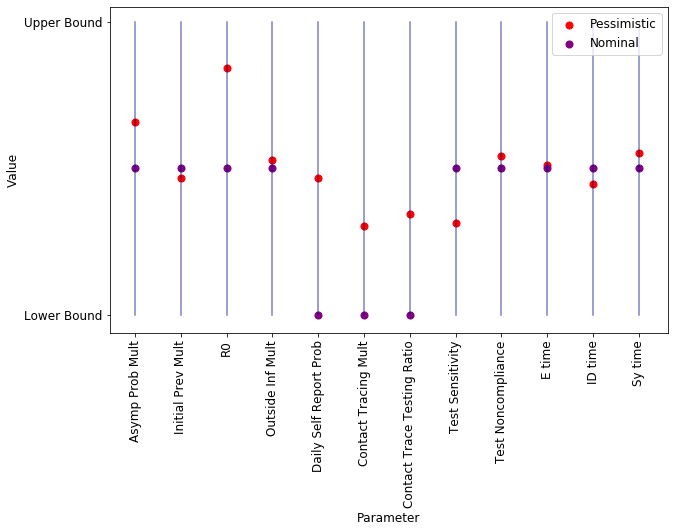

In [67]:
plt.figure(figsize=(10,6))
label = True

for index, param in enumerate(res_params):
    plt.plot([index, index], [0,1], color='navy', alpha=0.5)
    if label == True:
        plt.scatter(index, normalize_param(param, pess_scenario[param]), color='red', label='Pessimistic', s=50)
        plt.scatter(index, normalize_param(param, nominal_param_dict[param]), color='purple', label='Nominal', s=50)
        label = False
    else:
        plt.scatter(index, normalize_param(param, pess_scenario[param]), color='red', s=50)
        plt.scatter(index, normalize_param(param, nominal_param_dict[param]), color='purple', s=50)

plt.xticks(list(range(len(res_params))), ['Asymp Prob Mult', 'Initial Prev Mult', 'R0', 'Outside Inf Mult',
                                          'Daily Self Report Prob', 'Contact Tracing Mult', 'Contact Trace Testing Ratio',
                                          'Test Sensitivity', 'Test Noncompliance', 'E time', 'ID time', 'Sy time'])
plt.xticks(rotation = 90)
plt.yticks([0,1], ['Lower Bound', 'Upper Bound'])

plt.xlabel('Parameter')
plt.ylabel('Value')

plt.legend(loc='upper right')
plt.show()

# Checking for Bugs in [-0.1, 0.1]

In [11]:
lr_results = {'Intercept': 995.88,
'asymp_prob_mult': 941.91,
'inital_prev_mult': -191.00,
'R0': 666.95,
'outside_inf_mult': 174.12,
'daily_self_report_prob': -680.69,
'ct_mult': -1163.42,
'ct_testing_ratio': -924.52,
'test_sensitivity': -2727.62,
'test_noncompliance': 2361.98,
'E_time': 31.22,
'ID_time': -161.50,
'Sy_time': 152.59}

In [12]:
range_dict = dict()
res_params = ['asymp_prob_mult', 'inital_prev_mult', 'R0', 'outside_inf_mult', 'daily_self_report_prob',
                           'ct_mult', 'ct_testing_ratio', 'test_sensitivity', 'test_noncompliance', 'E_time', 'ID_time',
                          'Sy_time']
for param in res_params:
    range_dict[param] = (param_uncertainty[param][1] - param_uncertainty[param][0])/2

sum_squares = 0
for param in res_params:
    sum_squares += ((lr_results[param]*range_dict[param])/2) ** 2

pess_scenario = dict()
for param in res_params:
    pess_scenario[param] = np.mean(param_uncertainty[param]) + ((lr_results[param] * (range_dict[param])**2) / 2) / np.sqrt(sum_squares)
pess_scenario

{'asymp_prob_mult': 1.1537243162698188,
 'inital_prev_mult': 0.9674578245577438,
 'R0': 3.5227017549786117,
 'outside_inf_mult': 1.0296661967958411,
 'daily_self_report_prob': 0.3509075975984278,
 'ct_mult': 1.3017789646438236,
 'ct_testing_ratio': 0.8424822406289283,
 'test_sensitivity': 0.5256438210849786,
 'test_noncompliance': 0.10402429149482201,
 'E_time': 2.021276789891251,
 'ID_time': 2.8899358882947777,
 'Sy_time': 12.103991843994427}

In [13]:
centre_point = dict()
direction = dict()
for param in res_params:
    values = param_uncertainty[param]
    centre_point[param] = np.mean(values)
#     print(pess_scenario[param] - centre_point[param], norm.ppf(0.975))
    direction[param] = (pess_scenario[param] - centre_point[param]) / norm.ppf(0.975)

In [14]:
def generate_res_params_norm(conf_level):
    new_params = dict()
    for param in res_params:
        new_params[param] = centre_point[param] + norm.ppf(conf_level) * direction[param]
    return new_params

def generate_res_params_scalar(mult):
    new_params = dict()
    for param in res_params:
        new_params[param] = centre_point[param] + mult * direction[param] * norm.ppf(0.975)
    return new_params

def transform_res_param_dict_point(param_dict):
    new_point = list()
    for param in res_params:
        new_point.append(param_dict[param])
    new_point.append(0.5)
    new_point.append(0.5)
    new_point.append(0.97)
    new_point.append(0.5)
    return new_point

# pess_scenario, transform_res_param_dict_point(generate_res_params(0.975))

In [34]:
# conf_levels = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]
# conf_data = pd.DataFrame(columns=['conf_level']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

mult_levels = np.linspace(-0.025, 0.025, 5)
mult_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(new_point)
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 200)

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
    mult_data = mult_data.append(new_row, ignore_index=True)

In [35]:
mult_data

,mult,res_cornell_inf_10,res_cornell_inf_50,res_cornell_inf_90,res_ithaca_inf_10,res_ithaca_inf_50,res_ithaca_inf_90
0,-0.0250,143.0,179.5,219.0,173.0,194.5,221.0
1,-0.0125,151.0,182.0,228.0,172.9,195.5,219.1
2,0.0000,142.0,182.0,224.3,175.9,196.0,222.0
3,0.0125,199.0,290.0,393.9,175.9,205.0,230.1
4,0.0250,215.0,296.5,403.1,180.0,208.0,233.0


No handles with labels found to put in legend.


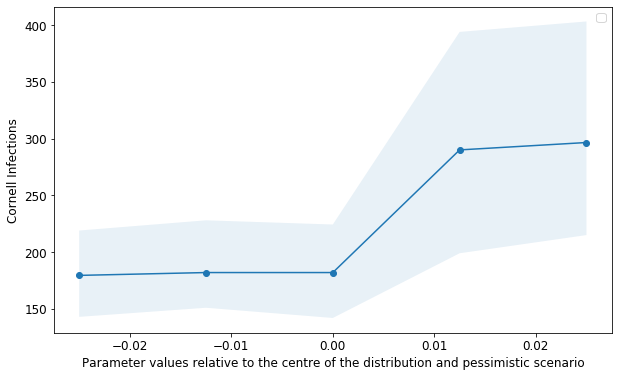

In [36]:
# f, axs = plt.subplots(1,2,sharex=True,figsize=(20,6))
plt.figure(figsize=(10,6))

plt.plot('mult', 'res_cornell_inf_50', marker='o', data=mult_data, label='_nolegend_')
plt.fill_between(x='mult', y1='res_cornell_inf_10', y2='res_cornell_inf_90', alpha=0.1, data=mult_data)

# plt.title('Cornell Infections')
plt.ylabel('Cornell Infections')
plt.xlabel('Parameter values relative to the centre of the distribution and pessimistic scenario')

plt.legend()
plt.show()

#### Debugging: Scale population by 100

In [14]:
# conf_levels = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.975, 0.99]
# conf_data = pd.DataFrame(columns=['conf_level']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

mult_levels = np.linspace(-0.025, 0.025, 5)
debug_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(new_point)
    for params in res_params_list:
        params['population_size'] *= 100
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 200)

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
    debug_data = debug_data.append(new_row, ignore_index=True)

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [67]:
new_point_1 = transform_res_param_dict_point(generate_res_params_scalar(-0.00001))
new_point_2 = transform_res_param_dict_point(generate_res_params_scalar(0))
new_point_3 = transform_res_param_dict_point(generate_res_params_scalar(0.00001))
np.array([new_point_1, new_point_2, new_point_3])
np.linalg.norm(np.array(new_point_1) - np.array(new_point_2)), np.linalg.norm(np.array(new_point_3) - np.array(new_point_2))

(1.0791669782506818e-05, 1.0791669782519581e-05)

In [25]:
(res_params_list_1, res_interaction_matrix_1, _), _ = adjust_params(new_point_1)
(res_params_list_2, res_interaction_matrix_2, _), _ = adjust_params(new_point_2)
(res_params_list_3, res_interaction_matrix_3, _), _ = adjust_params(new_point_3)

In [46]:
for index in range(len(res_params_list_1)):
    params_1 = res_params_list_1[index]
    params_2 = res_params_list_2[index]
    params_3 = res_params_list_3[index]
    
    for key in params_1.keys():
        print(params_1[key], params_2[key], params_3[key])
        if key not in ['ID_time_function', 'SyID_mild_time_function', 'SyID_severe_time_function', 'exposed_time_function',
                      'sample_QI_exit_function', 'sample_QS_exit_function', 'pre_ID_time_function', 'severity_prevalence', 'pre_ID_state']:
#             print(key, params_1[key], params_2[key], params_3[key])
            if np.abs(params_1[key] - params_2[key]) > 0.00001:
                print('Error')
            if np.abs(params_3[key] - params_2[key]) > 0.00001:
                print('Error')

[0.5199992  0.47200079 0.00600001 0.002     ] [0.52  0.472 0.006 0.002] [0.5200008  0.47199921 0.00599999 0.002     ]
4167 4167 4167
0.0015580005070070933 0.001558 0.0015579994929929065
8 8 8
<function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff0553b0> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff0577a0> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff057440>
20 20 20
<function poisson_waiting_function.<locals>.<lambda> at 0x7fd503affb00> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff057680> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff057050>
20 20 20
<function poisson_waiting_function.<locals>.<lambda> at 0x7fd503936f80> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff0575f0> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff0570e0>
7 7 7
<function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff057560> <function poisson_waiting_function.<locals>.<lambda> at 0x7fd4ff

In [45]:
np.max(np.abs(res_interaction_matrix_1 - res_interaction_matrix_2)), np.max(np.abs(res_interaction_matrix_3 - res_interaction_matrix_2))

(5.113508774812203e-05, 5.113508774812203e-05)

#### Test: recreate pessimistic scenario

In [52]:
pess_point = transform_res_param_dict_point(generate_res_params_scalar(1))
(pess_params_test, _, _), _ = adjust_params(new_point_1)
pess_point, pess_scenario
# for param in pess_scenario.keys():
#     print(pess_params_test[param], pess_scenario[param])

([1.1537243162698188,
  0.9674578245577438,
  3.5227017549786117,
  1.0296661967958411,
  0.3509075975984278,
  1.3017789646438236,
  0.8424822406289283,
  0.5256438210849786,
  0.10402429149482201,
  2.021276789891251,
  2.8899358882947777,
  12.103991843994427,
  0.5,
  0.5,
  0.97,
  0.5],
 {'asymp_prob_mult': 1.1537243162698188,
  'inital_prev_mult': 0.9674578245577438,
  'R0': 3.5227017549786117,
  'outside_inf_mult': 1.0296661967958411,
  'daily_self_report_prob': 0.3509075975984278,
  'ct_mult': 1.3017789646438236,
  'ct_testing_ratio': 0.8424822406289283,
  'test_sensitivity': 0.5256438210849786,
  'test_noncompliance': 0.10402429149482201,
  'E_time': 2.021276789891251,
  'ID_time': 2.8899358882947777,
  'Sy_time': 12.103991843994427})

# Test: varying 1 parameter at a time from nominal to generate params (0.0001)

In [ ]:
mult_levels = np.linspace(-0.025, 0.025, 5)
mult_data = pd.DataFrame(columns=['mult']+['res_cornell_inf_10','res_cornell_inf_50','res_cornell_inf_90','res_ithaca_inf_10','res_ithaca_inf_50','res_ithaca_inf_90'])

for mult in mult_levels:
    new_point = transform_res_param_dict_point(generate_res_params_scalar(mult))
    (res_params_list, res_interaction_matrix, res_group_names), (virtual_params_list, virtual_interaction_matrix, virtual_group_names) = adjust_params(new_point)
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(res_params_list, res_interaction_matrix, res_group_names, res_test_policy, 112, 200)

    new_row = dict()
    new_row['mult'] = mult

    res_cornell_inf_quantiles, res_ithaca_inf_quantiles = get_stats(res_inf_matrix)
    new_row['res_cornell_inf_10'] = res_cornell_inf_quantiles[0]
    new_row['res_cornell_inf_50'] = res_cornell_inf_quantiles[1]
    new_row['res_cornell_inf_90'] = res_cornell_inf_quantiles[2]
    new_row['res_ithaca_inf_10'] = res_ithaca_inf_quantiles[0]
    new_row['res_ithaca_inf_50'] = res_ithaca_inf_quantiles[1]
    new_row['res_ithaca_inf_90'] = res_ithaca_inf_quantiles[2]

#     vir_cornell_inf_quantiles, vir_ithaca_inf_quantiles = get_stats(virtual_inf_matrix)
#     new_row['vir_cornell_inf_10'] = vir_cornell_inf_quantiles[0]
#     new_row['vir_cornell_inf_50'] = vir_cornell_inf_quantiles[1]
#     new_row['vir_cornell_inf_90'] = vir_cornell_inf_quantiles[2]
#     new_row['vir_ithaca_inf_10'] = vir_ithaca_inf_quantiles[0]
#     new_row['vir_ithaca_inf_50'] = vir_ithaca_inf_quantiles[1]
#     new_row['vir_ithaca_inf_90'] = vir_ithaca_inf_quantiles[2]
    
    mult_data = mult_data.append(new_row, ignore_index=True)

In [68]:
zero_point = transform_res_param_dict_point(generate_res_params_scalar(0))
positive_point = transform_res_param_dict_point(generate_res_params_scalar(0.0001))

(res_params_list_0, res_interaction_matrix_0, _), _ = adjust_params(zero_point)
(res_params_list_pos, res_interaction_matrix_pos, _), _ = adjust_params(positive_point)

# 0 point sim: 182

params_adjusted = ['severity_prevalence', 'initial_ID_prevalence', 'daily_outside_infection_p', 'severe_symptoms_daily_self_report_p',
                  'cases_isolated_per_contact', 'contact_trace_testing_frac', 'test_protocol_QFNR', 'exposed_time_function',
                  'ID_time_function', 'SyID_mild_time_function', 'SyID_severe_time_function']

for param_to_change in params_adjusted:
    sim_params = list()

    zero_point = transform_res_param_dict_point(generate_res_params_scalar(0))
    (res_params_list_0, res_interaction_matrix_0, res_group_names_0), _ = adjust_params(zero_point)

    positive_point = transform_res_param_dict_point(generate_res_params_scalar(0.0001))
    (res_params_list_pos, res_interaction_matrix_pos, _), _ = adjust_params(positive_point)
    
    # Adjusting 1 param
    
    for index, param in enumerate(res_params_list_0):
        param_copy = param.copy()
        param_copy[param_to_change] = res_params_list_pos[index][param_to_change]
        sim_params.append(param_copy)
    
    # Running simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(sim_params, res_interaction_matrix_0, res_group_names_0, res_test_policy, 112, 15)
    print(param_to_change, get_stats(res_inf_matrix)[0][1])

severity_prevalence 183.0
initial_ID_prevalence 175.0
daily_outside_infection_p 169.0
severe_symptoms_daily_self_report_p 171.0
cases_isolated_per_contact 179.0
contact_trace_testing_frac 299.0
test_protocol_QFNR 192.0
exposed_time_function 188.0
ID_time_function 187.0
SyID_mild_time_function 182.0
SyID_severe_time_function 178.0


In [72]:
zero_point = transform_res_param_dict_point(generate_res_params_scalar(0))
positive_point = transform_res_param_dict_point(generate_res_params_scalar(0.0001))

(res_params_list_0, res_interaction_matrix_0, _), _ = adjust_params(zero_point)
(res_params_list_pos, res_interaction_matrix_pos, _), _ = adjust_params(positive_point)

# 0 point sim: 182

params_adjusted = ['severity_prevalence', 'initial_ID_prevalence', 'daily_outside_infection_p', 'severe_symptoms_daily_self_report_p',
                  'cases_isolated_per_contact', 'contact_trace_testing_frac', 'test_protocol_QFNR', 'exposed_time_function',
                  'ID_time_function', 'SyID_mild_time_function', 'SyID_severe_time_function']

for param_to_change in params_adjusted:
    sim_params = list()

    zero_point = transform_res_param_dict_point(generate_res_params_scalar(0))
    (res_params_list_0, res_interaction_matrix_0, res_group_names_0), _ = adjust_params(zero_point)

    positive_point = transform_res_param_dict_point(generate_res_params_scalar(0.0001))
    (res_params_list_pos, res_interaction_matrix_pos, _), _ = adjust_params(positive_point)
    
    # Adjusting 1 param
    
    for index, param in enumerate(res_params_list_0):
        param_copy = param.copy()
        param_copy[param_to_change] = res_params_list_pos[index][param_to_change]
        sim_params.append(param_copy)
    
    # Running simulation
    res_test_policy = [2/7,2/7,1/7,1/7,2/7,1/7,1/30,0]
    res_tests_per_day, res_inf_matrix, res_hosp_matrix = evaluate_testing_policy(sim_params, res_interaction_matrix_0, res_group_names_0, res_test_policy, 112, 15)
    print(param_to_change, get_stats(res_inf_matrix)[0][1])

severity_prevalence 176.0
initial_ID_prevalence 188.0
daily_outside_infection_p 196.0
severe_symptoms_daily_self_report_p 186.0
cases_isolated_per_contact 181.0
contact_trace_testing_frac 275.0
test_protocol_QFNR 183.0
exposed_time_function 179.0
ID_time_function 185.0
SyID_mild_time_function 186.0
SyID_severe_time_function 203.0


In [73]:
zero_point = transform_res_param_dict_point(generate_res_params_scalar(0))
(res_params_list_0, res_interaction_matrix_0, res_group_names_0), _ = adjust_params(zero_point)

positive_point = transform_res_param_dict_point(generate_res_params_scalar(0.0001))
(res_params_list_pos, res_interaction_matrix_pos, _), _ = adjust_params(positive_point)

for index in range(len(res_params_list_0)):
    print(res_params_list_0[index]['cases_isolated_per_contact'], res_params_list_pos[index]['cases_isolated_per_contact'])
    print(res_params_list_0[index]['contact_trace_testing_frac'], res_params_list_pos[index]['contact_trace_testing_frac'])

1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
1.275 1.2749831512119947
1.0 0.9999842482240628
